In [1]:
import google.generativeai as genai
from getpass import getpass
import pandas as pd
import json
from tqdm import tqdm

In [ ]:
import requests

API_URL = "https://api.perplexity.ai/chat/completions"
API_KEY = ""  # your key

payload = {
    "model": "sonar-pro",
    "messages": [
        {"role": "user", "content": "Hi, what is the model used?"}
    ],
    "max_tokens": 1000
}

headers = {
    "Authorization": f"Bearer {API_KEY}",
    "Content-Type": "application/json"
}

resp = requests.post(API_URL, headers=headers, json=payload)

if resp.status_code == 200:
    data = resp.json()
    reply = data["choices"][0]["message"]["content"]
    print("Assistant reply:", reply)
else:
    print("Error:", resp.status_code, resp.text)



Assistant reply: I am an **AI assistant powered by a large language model (LLM) in the GPT‑4 family**, based on the **transformer** architecture used for generative text models like GPT‑4 and similar systems.[1][4][5][6]


In [3]:

import requests
import pandas as pd
import json
import re
from tqdm import tqdm


In [ ]:
API_KEY = ""   # replace with your real key
API_URL = "https://api.perplexity.ai/chat/completions"

def call_llm(prompt):
    payload = {
        "model": "sonar-pro",
        "messages": [
            {"role": "user", "content": prompt}
        ],
        "max_tokens": 500
    }

    headers = {
        "Authorization": f"Bearer {API_KEY}",
        "Content-Type": "application/json"
    }

    resp = requests.post(API_URL, headers=headers, json=payload)

    if resp.status_code == 200:
        data = resp.json()
        return data["choices"][0]["message"]["content"]
    else:
        return None


In [6]:
df = pd.read_csv('/content/yelp.csv')
df = df[['text', 'stars']]
sample_df = df.sample(200, random_state=42).reset_index(drop=True)
sample_df.head()


,text,stars
0,We got here around midnight last Friday... the...,4
1,Brought a friend from Louisiana here. She say...,5
2,"Every friday, my dad and I eat here. We order ...",3
3,"My husband and I were really, really disappoin...",1
4,Love this place! Was in phoenix 3 weeks for w...,5


In [7]:
def prompt_zero_shot(review):
    return f"""
You are a strict JSON generator.

Predict Yelp rating (1 to 5).
Return ONLY pure JSON.

Review: "{review}"

Format:
{{
 "predicted_stars": number,
 "explanation": "short reason"
}}
"""


In [8]:
def prompt_contextual(review):
    return f"""
You are an expert sentiment analyst for Yelp reviews.

Use this rating scale:
1 = very negative (strong dissatisfaction)
2 = negative
3 = neutral or mixed
4 = positive
5 = very positive (strong satisfaction)

Task:
- Read the review carefully.
- Choose the best rating from 1 to 5.
- Provide a short explanation.

Important rules:
- Output ONLY raw JSON (no markdown, no extra text).
- Do not include any comments or formatting outside JSON.

Review: "{review}"

Return JSON exactly in this format:
{{
 "predicted_stars": number,
 "explanation": "short reason"
}}
"""


In [9]:


def prompt_self_eval(review):
    return f"""
You are analyzing a Yelp review.

First, internally decide a rating from 1 to 5 using this scale:
1 = very negative
2 = negative
3 = neutral or mixed
4 = positive
5 = very positive

Then, internally double-check whether your chosen rating matches
the tone and intensity of the review. If it does not, internally adjust it.

Important:
- Do NOT show your reasoning or checks.
- Output ONLY raw JSON (no markdown, no extra text).

Review: "{review}"

Return JSON exactly in this format:
{{
 "predicted_stars": number,
 "explanation": "very brief reason"
}}
"""


In [10]:
def extract_json(output):
    if output is None:
        return None

    match = re.search(r"\{.*\}", output, re.DOTALL)
    if not match:
        return None

    try:
        return json.loads(match.group())
    except:
        return None


In [11]:
def evaluate_prompt(prompt_fn):
    results = []

    for i, row in tqdm(sample_df.iterrows(), total=len(sample_df)):
        review = row['text']
        gold = row['stars']

        prompt = prompt_fn(review)
        output = call_llm(prompt)
        parsed = extract_json(output)

        if parsed is None:
            results.append({"gold": gold, "pred": None, "valid_json": 0})
            continue

        pred = parsed.get("predicted_stars", None)
        results.append({"gold": gold, "pred": pred, "valid_json": 1})

    return pd.DataFrame(results)


In [12]:
res_zero = evaluate_prompt(prompt_zero_shot)
res_cont = evaluate_prompt(prompt_contextual)
res_sel  = evaluate_prompt(prompt_self_eval)


100%|██████████| 200/200 [08:39<00:00,  2.60s/it]


In [13]:
def compute_metrics(df):
    acc = (df['gold'] == df['pred']).mean()
    json_rate = df['valid_json'].mean()
    return acc, json_rate

print("Zero-shot:", compute_metrics(res_zero))
print("Contextual:", compute_metrics(res_cont))
print("Self-Evalutaion:", compute_metrics(res_sel))


Zero-shot: (np.float64(0.58), np.float64(1.0))
Contextual: (np.float64(0.515), np.float64(1.0))
Self-Evalutaion: (np.float64(0.585), np.float64(0.995))



=== Analysis for Zero-shot ===
Samples (valid): 200
Accuracy: 0.585

Classification report:

              precision    recall  f1-score   support

           1      0.765     0.722     0.743        18
           2      0.524     0.647     0.579        17
           3      0.812     0.394     0.531        33
           4      0.707     0.367     0.483        79
           5      0.486     0.962     0.646        53

    accuracy                          0.585       200
   macro avg      0.659     0.619     0.596       200
weighted avg      0.656     0.585     0.566       200



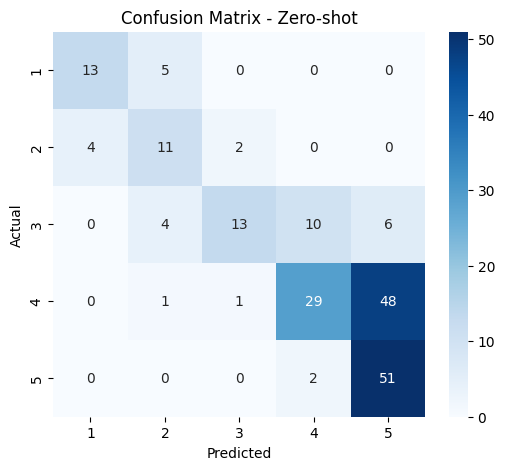

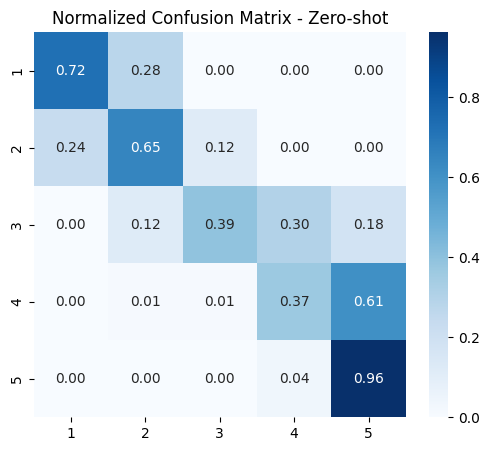


=== Analysis for Contextual ===
Samples (valid): 200
Accuracy: 0.515

Classification report:

              precision    recall  f1-score   support

           1      0.824     0.778     0.800        18
           2      0.476     0.588     0.526        17
           3      0.545     0.182     0.273        33
           4      0.579     0.278     0.376        79
           5      0.451     0.962     0.614        53

    accuracy                          0.515       200
   macro avg      0.575     0.558     0.518       200
weighted avg      0.553     0.515     0.473       200



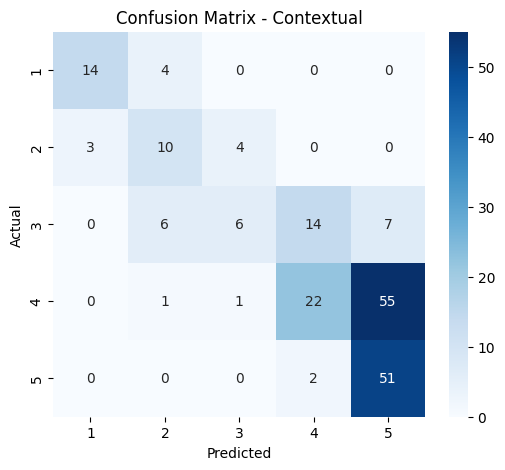

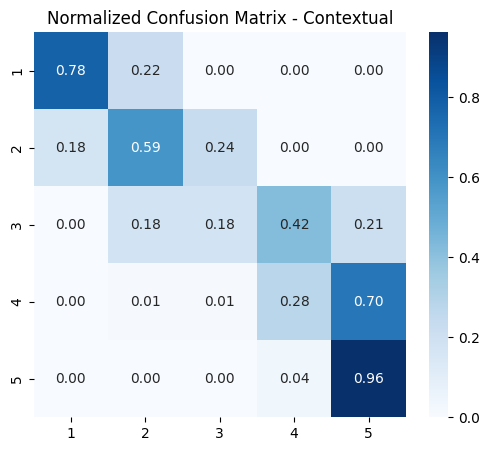


=== Analysis for Self-Evaluation ===
Samples (valid): 199
Accuracy: 0.5879396984924623

Classification report:

              precision    recall  f1-score   support

           1      0.867     0.722     0.788        18
           2      0.542     0.765     0.634        17
           3      0.769     0.303     0.435        33
           4      0.660     0.418     0.512        79
           5      0.495     0.923     0.644        52

    accuracy                          0.588       199
   macro avg      0.666     0.626     0.603       199
weighted avg      0.644     0.588     0.569       199



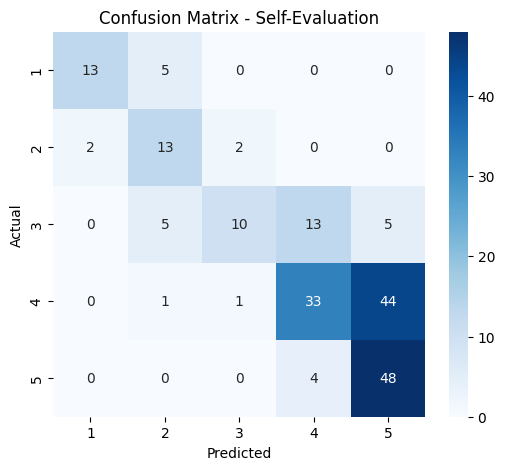

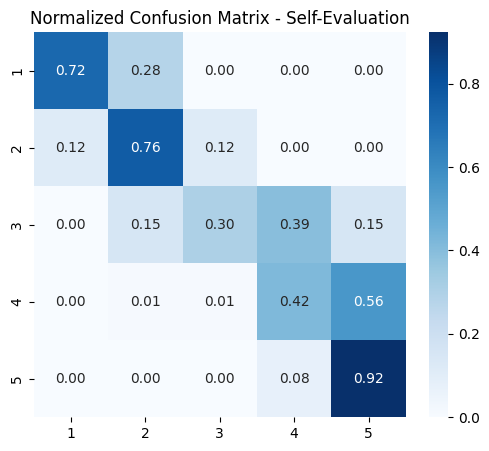

In [15]:
import numpy as np
import pandas as pd
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns

def analyze_results(df, label):
    # drop invalid
    df_valid = df[df['pred'].notnull()].copy()
    y_true = df_valid['gold'].astype(int).values
    y_pred = df_valid['pred'].astype(int).values

    print(f"\n=== Analysis for {label} ===")
    print("Samples (valid):", len(df_valid))
    print("Accuracy:", (y_true==y_pred).mean())

    print("\nClassification report:\n")
    print(classification_report(y_true, y_pred, digits=3))

    cm = confusion_matrix(y_true, y_pred, labels=[1,2,3,4,5])
    cm_norm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    plt.figure(figsize=(6,5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=[1,2,3,4,5], yticklabels=[1,2,3,4,5])
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title(f'Confusion Matrix - {label}')
    plt.show()

    plt.figure(figsize=(6,5))
    sns.heatmap(cm_norm, annot=True, fmt='.2f', cmap='Blues',
                xticklabels=[1,2,3,4,5], yticklabels=[1,2,3,4,5])
    plt.title(f'Normalized Confusion Matrix - {label}')
    plt.show()

# Run for each prompt
analyze_results(res_zero, "Zero-shot")
analyze_results(res_cont,  "Contextual")
analyze_results(res_sel,  "Self-Evaluation")
